# Chapter 2: Cross Validation

This notebook explains **Cross Validation** - how to use limited data effectively for both Training and Testing without "cheating" (data leakage).

## The Big Picture
- **Problem**: Training and testing on the same data = overfitting (model memorizes instead of learning)
- **Solution**: Cross Validation = use all data for both training AND testing through iterative splits
- **Benefit**: Get honest performance estimates and ensure your model works on new, unseen data

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

## 2. Load and Visualize Toy Dataset

Our simple dataset: **Hours Studied vs Exam Score**
- Feature (X): Hours studied
- Target (y): Exam score

Dataset:
    hours_studied  exam_score
0               1   46.490142
1               2   54.585207
2               3   61.943066
3               4   69.569090
4               5   69.297540
5               6   74.297589
6               7   82.737638
7               8   87.302304
8               9   86.591577
9              10   93.627680
10             11   88.609747
11             12   98.602811

Total samples: 12


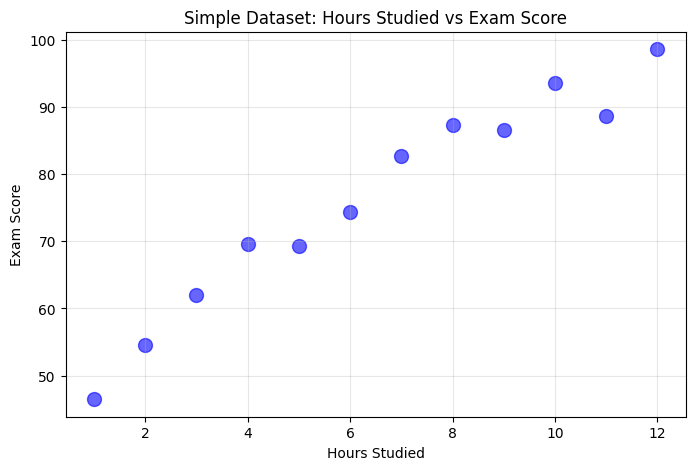

In [2]:
# Create a simple toy dataset with some realistic noise
np.random.seed(42)  # For reproducibility
hours = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
# Base scores with added noise
base_scores = np.array([45, 55, 60, 65, 70, 75, 78, 85, 88, 92, 90, 100])
noise = np.random.normal(0, 3, len(hours))  # Add random noise
exam_scores = base_scores + noise

data = {
    'hours_studied': hours,
    'exam_score': exam_scores
}
df = pd.DataFrame(data)

print("Dataset:")
print(df)
print(f"\nTotal samples: {len(df)}")

# Extract features (X) and target (y)
X = df[['hours_studied']].values
y = df['exam_score'].values

# Visualize the data
plt.figure(figsize=(8, 5))
plt.scatter(X, y, s=100, alpha=0.6, color='blue')
plt.xlabel('Hours Studied')
plt.ylabel('Exam Score')
plt.title('Simple Dataset: Hours Studied vs Exam Score')
plt.grid(True, alpha=0.3)
plt.show()

## 3. Problem: Data Leakage 🚨

**What happens if we train and test on the SAME data?**

We'll train two models:
1. Linear model (simple straight line)
2. Polynomial model (complex curved line)

Then test both on the same data they trained on.

❌ WRONG WAY: Training and Testing on Same Data (Data Leakage)

Linear Model - RMSE: 3.60
Polynomial Model (degree=11) - RMSE: 0.253198

⚠️  This polynomial passes through EVERY training point → zero training error.
   It massively overfits and will perform poorly on new data!



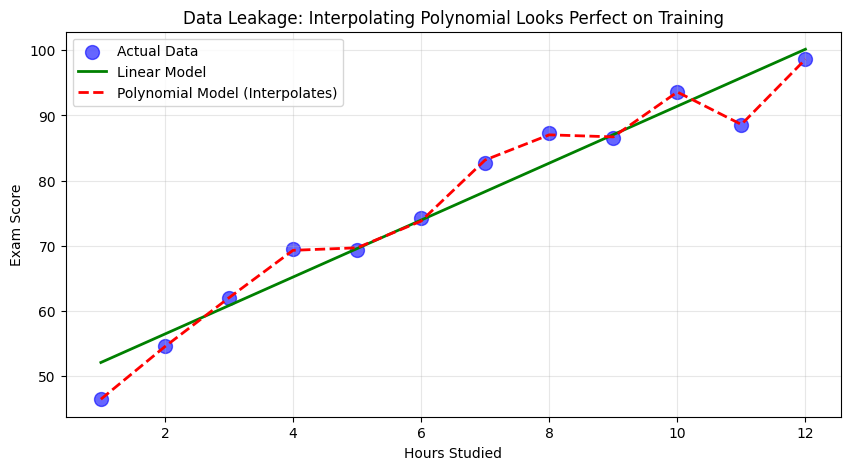

In [3]:
print("❌ WRONG WAY: Training and Testing on Same Data (Data Leakage)\n")

# Model 1: Linear Regression
linear_model = LinearRegression()
linear_model.fit(X, y)  # Train on all data
y_pred_linear = linear_model.predict(X)  # Test on same data
mse_linear = mean_squared_error(y, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)

print(f"Linear Model - RMSE: {rmse_linear:.2f}")

# Model 2: Polynomial Regression (high degree to interpolate all points)
degree_max = len(X) - 1  # ensures Vandermonde is square and invertible
poly_features = PolynomialFeatures(degree=degree_max)
X_poly = poly_features.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, y)  # Train on all data
y_pred_poly = poly_model.predict(X_poly)  # Test on same data
mse_poly = mean_squared_error(y, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)

print(f"Polynomial Model (degree={degree_max}) - RMSE: {rmse_poly:.6f}")
print("\n⚠️  This polynomial passes through EVERY training point → zero training error.")
print("   It massively overfits and will perform poorly on new data!\n")

# Visualize both models
plt.figure(figsize=(10, 5))

# Plot data points
plt.scatter(X, y, s=100, alpha=0.6, color='blue', label='Actual Data')

# Sort X for smooth curves
X_sorted = np.sort(X, axis=0)

# Linear model
y_linear_sorted = linear_model.predict(X_sorted)
plt.plot(X_sorted, y_linear_sorted, color='green', linewidth=2, label='Linear Model')

# Polynomial model (interpolating curve)
X_poly_sorted = poly_features.transform(X_sorted)
y_poly_sorted = poly_model.predict(X_poly_sorted)
plt.plot(X_sorted, y_poly_sorted, color='red', linewidth=2, linestyle='--', label='Polynomial Model (Interpolates)')

plt.xlabel('Hours Studied')
plt.ylabel('Exam Score')
plt.title('Data Leakage: Interpolating Polynomial Looks Perfect on Training')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Solution: 4-Fold Cross Validation ✅

**How it works:**
1. **Split**: Divide data into 4 equal groups (called "folds")
2. **Iterate**: Use 3 folds for training, 1 fold for testing (repeat 4 times)
3. **Average**: Report the average performance across all folds

This way, every data point gets used for BOTH training AND testing, just in different runs!

In [4]:
print("✅ CORRECT WAY: 4-Fold Cross Validation\n")

# Set up 4-fold cross validation
kfold = KFold(n_splits=4, shuffle=False)

# Store results for both models
linear_scores = []
poly_scores = []

fold_num = 1
for train_idx, test_idx in kfold.split(X):
    print(f"\n--- Fold {fold_num} ---")
    
    # Split data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    print(f"Training on {len(train_idx)} samples, Testing on {len(test_idx)} samples")
    
    # Linear Model
    linear = LinearRegression()
    linear.fit(X_train, y_train)
    y_pred = linear.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    linear_scores.append(rmse)
    print(f"Linear Model - RMSE: {rmse:.2f}")
    
    # Polynomial Model
    degree_max = len(X_train) - 1
    poly_f = PolynomialFeatures(degree=degree_max)
    X_train_poly = poly_f.fit_transform(X_train)
    X_test_poly = poly_f.transform(X_test)
    poly = LinearRegression()
    poly.fit(X_train_poly, y_train)
    y_pred = poly.predict(X_test_poly)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    poly_scores.append(rmse)
    print(f"Polynomial Model - RMSE: {rmse:.2f}")
    
    fold_num += 1

print("\n" + "="*50)
print("RESULTS AFTER 4-FOLD CROSS VALIDATION:")
print("="*50)
print(f"\nLinear Model:")
print(f"  Fold Errors: {[f'{score:.2f}' for score in linear_scores]}")
print(f"  Average Error (RMSE): {np.mean(linear_scores):.2f}")

print(f"\nPolynomial Model:")
print(f"  Fold Errors: {[f'{score:.2f}' for score in poly_scores]}")
print(f"  Average Error (RMSE): {np.mean(poly_scores):.2f}")

print("\n✅ NOW the polynomial model's true performance is revealed!")
print("   It's actually WORSE than the linear model on unseen data!")
print("   The linear model wins! (better RMSE)")

✅ CORRECT WAY: 4-Fold Cross Validation


--- Fold 1 ---
Training on 9 samples, Testing on 3 samples
Linear Model - RMSE: 8.13
Polynomial Model - RMSE: 7171.61

--- Fold 2 ---
Training on 9 samples, Testing on 3 samples
Linear Model - RMSE: 3.02
Polynomial Model - RMSE: 31.18

--- Fold 3 ---
Training on 9 samples, Testing on 3 samples
Linear Model - RMSE: 4.60
Polynomial Model - RMSE: 24.75

--- Fold 4 ---
Training on 9 samples, Testing on 3 samples
Linear Model - RMSE: 8.29
Polynomial Model - RMSE: 4896.67

RESULTS AFTER 4-FOLD CROSS VALIDATION:

Linear Model:
  Fold Errors: ['8.13', '3.02', '4.60', '8.29']
  Average Error (RMSE): 6.01

Polynomial Model:
  Fold Errors: ['7171.61', '31.18', '24.75', '4896.67']
  Average Error (RMSE): 3031.05

✅ NOW the polynomial model's true performance is revealed!
   It's actually WORSE than the linear model on unseen data!
   The linear model wins! (better RMSE)


## 5. Standard: 10-Fold Cross Validation

**Better for larger datasets.** Same idea but split into 10 groups instead of 4.

In [5]:
print("✅ 10-Fold Cross Validation\n")

kfold_10 = KFold(n_splits=10, shuffle=True, random_state=42)

linear_scores_10 = []
poly_scores_10 = []

for train_idx, test_idx in kfold_10.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Linear
    linear = LinearRegression()
    linear.fit(X_train, y_train)
    rmse = np.sqrt(mean_squared_error(y_test, linear.predict(X_test)))
    linear_scores_10.append(rmse)
    
    # Polynomial
    poly_f = PolynomialFeatures(degree=5)
    X_train_poly = poly_f.fit_transform(X_train)
    X_test_poly = poly_f.transform(X_test)
    poly = LinearRegression()
    poly.fit(X_train_poly, y_train)
    rmse = np.sqrt(mean_squared_error(y_test, poly.predict(X_test_poly)))
    poly_scores_10.append(rmse)

print(f"Linear Model - Average RMSE (10-Fold): {np.mean(linear_scores_10):.2f}")
print(f"Polynomial Model - Average RMSE (10-Fold): {np.mean(poly_scores_10):.2f}")

✅ 10-Fold Cross Validation

Linear Model - Average RMSE (10-Fold): 3.37
Polynomial Model - Average RMSE (10-Fold): 6.11


## 6. For Small Datasets: Leave-One-Out Cross Validation

**Use when you have very little data.** Train on ALL samples except 1, test on that 1 sample. Repeat for EVERY single sample.

In [6]:
print("✅ Leave-One-Out Cross Validation\n")
print(f"We have {len(X)} samples, so we'll do {len(X)} iterations\n")

loo = LeaveOneOut()

linear_scores_loo = []
poly_scores_loo = []

iteration = 0
for train_idx, test_idx in loo.split(X):
    iteration += 1
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Linear
    linear = LinearRegression()
    linear.fit(X_train, y_train)
    error = abs(y_test[0] - linear.predict(X_test)[0])
    linear_scores_loo.append(error)
    
    # Polynomial
    poly_f = PolynomialFeatures(degree=5)
    X_train_poly = poly_f.fit_transform(X_train)
    X_test_poly = poly_f.transform(X_test)
    poly = LinearRegression()
    poly.fit(X_train_poly, y_train)
    error = abs(y_test[0] - poly.predict(X_test_poly)[0])
    poly_scores_loo.append(error)
    
    if iteration <= 3:
        print(f"Iteration {iteration}: Train on {len(train_idx)} samples, Test on 1")

print(f"... ({len(X) - 3} more iterations)")

print(f"\nLinear Model - Average Error (Leave-One-Out): {np.mean(linear_scores_loo):.2f}")
print(f"Polynomial Model - Average Error (Leave-One-Out): {np.mean(poly_scores_loo):.2f}")

✅ Leave-One-Out Cross Validation

We have 12 samples, so we'll do 12 iterations

Iteration 1: Train on 11 samples, Test on 1
Iteration 2: Train on 11 samples, Test on 1
Iteration 3: Train on 11 samples, Test on 1
... (9 more iterations)

Linear Model - Average Error (Leave-One-Out): 3.50
Polynomial Model - Average Error (Leave-One-Out): 6.23


## 7. Summary: Compare All Methods 📊

FINAL COMPARISON: Which Model Really Works Best?

❌ DATA LEAKAGE (Train and Test on Same Data - WRONG):
  Linear Model RMSE: 3.60
  Polynomial Model RMSE: 0.25
  ↳ Polynomial looks amazing, but it's overfitting!

✅ 4-FOLD CROSS VALIDATION (HONEST):
  Linear Model RMSE: 6.01
  Polynomial Model RMSE: 3031.05
  ↳ Linear wins! It generalizes better to new data

✅ 10-FOLD CROSS VALIDATION (STANDARD):
  Linear Model RMSE: 3.37
  Polynomial Model RMSE: 6.11

✅ LEAVE-ONE-OUT (FOR SMALL DATA):
  Linear Model Average Error: 3.50
  Polynomial Model Average Error: 6.23


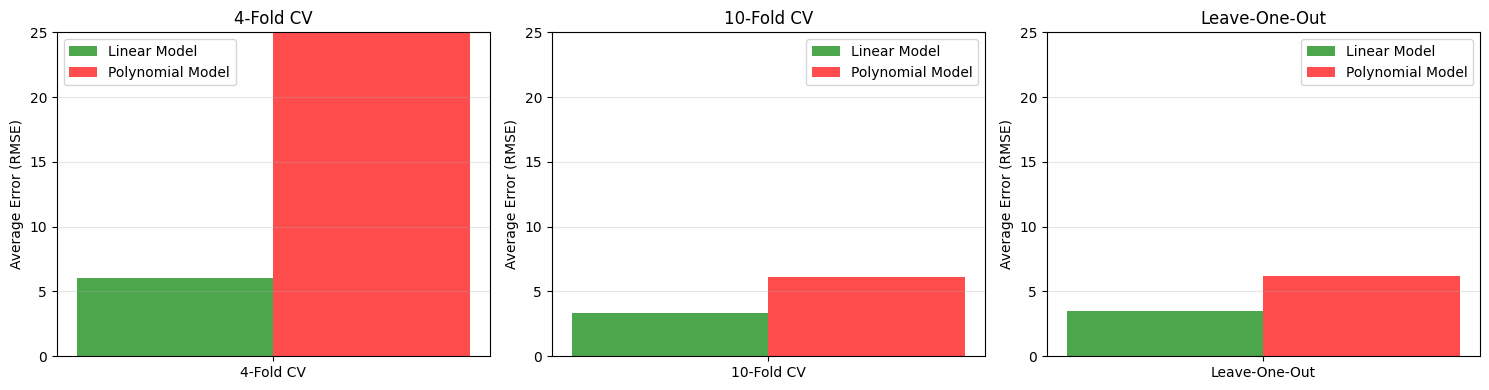


KEY INSIGHTS:

1. Data Leakage makes models look AMAZING but they won't work on new data
2. Cross Validation gives you HONEST performance estimates
3. Use 10-Fold CV for most datasets (standard choice for big datasets)
4. Use Leave-One-Out only for tiny datasets (very slow for large data)
5. The LINEAR model is actually the winner here! Simple > Complex



In [7]:
print("="*60)
print("FINAL COMPARISON: Which Model Really Works Best?")
print("="*60)

# Data Leakage Results (MISLEADING)
print("\n❌ DATA LEAKAGE (Train and Test on Same Data - WRONG):")
print(f"  Linear Model RMSE: {rmse_linear:.2f}")
print(f"  Polynomial Model RMSE: {rmse_poly:.2f}")
print("  ↳ Polynomial looks amazing, but it's overfitting!")

# Cross Validation Results (HONEST)
print("\n✅ 4-FOLD CROSS VALIDATION (HONEST):")
print(f"  Linear Model RMSE: {np.mean(linear_scores):.2f}")
print(f"  Polynomial Model RMSE: {np.mean(poly_scores):.2f}")
print("  ↳ Linear wins! It generalizes better to new data")

print("\n✅ 10-FOLD CROSS VALIDATION (STANDARD):")
print(f"  Linear Model RMSE: {np.mean(linear_scores_10):.2f}")
print(f"  Polynomial Model RMSE: {np.mean(poly_scores_10):.2f}")

print("\n✅ LEAVE-ONE-OUT (FOR SMALL DATA):")
print(f"  Linear Model Average Error: {np.mean(linear_scores_loo):.2f}")
print(f"  Polynomial Model Average Error: {np.mean(poly_scores_loo):.2f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

methods = ['4-Fold CV', '10-Fold CV', 'Leave-One-Out']
linear_means = [np.mean(linear_scores), np.mean(linear_scores_10), np.mean(linear_scores_loo)]
poly_means = [np.mean(poly_scores), np.mean(poly_scores_10), np.mean(poly_scores_loo)]

x = np.arange(len(methods))
width = 0.35

for idx, ax in enumerate(axes):
    if idx < 3:
        ax.bar(x[idx] - width/2, linear_means[idx], width, label='Linear Model', color='green', alpha=0.7)
        ax.bar(x[idx] + width/2, poly_means[idx], width, label='Polynomial Model', color='red', alpha=0.7)
        ax.set_ylabel('Average Error (RMSE)')
        ax.set_title(methods[idx])
        ax.set_xticks([x[idx]])
        ax.set_xticklabels([methods[idx]])
        ax.legend()
        ax.set_ylim([0, 25])
        ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY INSIGHTS:")
print("="*60)
print("""
1. Data Leakage makes models look AMAZING but they won't work on new data
2. Cross Validation gives you HONEST performance estimates
3. Use 10-Fold CV for most datasets (standard choice for big datasets)
4. Use Leave-One-Out only for tiny datasets (very slow for large data)
5. The LINEAR model is actually the winner here! Simple > Complex
""")